# STAGE 1: 
---

In [2]:
# %load Record_audio.py


#import pyaudio
#import wave

import pyaudio
import wave
import keyboard as kb
import librosa
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

def get_network():

    net = torch.nn.Sequential()
    #os.chdir("C:\\Users\\vguha\\Google Drive\\AIML\\AIML_CLASS_IIIT\\Hackathon I-20180708T035053Z-001\\")
    #print(os.path.abspath(os.curdir))
    saved_net = torch.load("./net_speech_89.pt").cpu()

    for index, module in enumerate(saved_net):
        net.add_module("layer"+str(index),module)
        if (index+1)%17 == 0 :
            break
    return net

def wait_for_key() :
	while True:
	    try:
	        if kb.is_pressed('s'):
 	             return
	        else:
	            pass
	    except:
	        continue 


#Use this function to return the deep learning audio features by providing the audio file path
#filepath for path of the audio file
#sr(samplingrate = 8000) for all the recordings and newly recorded audio files use the same sampling rate
#n_mfcc =30
#n_mels = 128
#frames = 15
def get_features(filepath, sr=8000, n_mfcc=30, n_mels=128, frames = 15):
    y, sr = librosa.load(filepath, sr=sr)
    D = np.abs(librosa.stft(y))**2
    S = librosa.feature.melspectrogram(S=D)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S,ref=np.max)
    features = librosa.feature.mfcc(S=log_S, n_mfcc=n_mfcc)
    if features.shape[1] < frames :
        features = np.hstack((features, np.zeros((n_mfcc, frames - features.shape[1]))))
    elif features.shape[1] > frames:
        features = features[:, :frames]
    # Find 1st order delta_mfcc
    delta1_mfcc = librosa.feature.delta(features, order=1)

    # Find 2nd order delta_mfcc
    delta2_mfcc = librosa.feature.delta(features, order=2)
    features = np.hstack((delta1_mfcc.flatten(), delta2_mfcc.flatten()))
    features = features.flatten()[np.newaxis, :]
    features = Variable(torch.from_numpy(features)).float()
    deep_net = get_network()
    deep_features = deep_net(features)
    #print(features.shape)
    #print(audio_file)
    #features.flatten()[np.newaxis, :]
    return deep_features.data.numpy().flatten()


#Function to record the voice sample, total recording time is 1 sec
#Username is the identifier for the person recording the voice
#j is the label for the sample For Example : if you recording the sample for "one" label is 1, for "yes" it is 11 etc.
#v is the unique identifier for each sample recorded by a person 
#Example username is r1 , j is 1 (label), v is 10 (10th sample recorded by that person) audio file will be saved with the name 1_r1_10.wav
#returns the filepath after recording
def record_voice(Username, j, v, dir ):
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 8000
    CHUNK = 1024
    RECORD_SECONDS = 1
    WAVE_OUTPUT_FILENAME = "file.wav"
    audio = pyaudio.PyAudio()
 
# start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
    print("recording...")
    frames = []
 
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("finished recording")
 
 
# stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()
    WAVE_OUTPUT_FILENAME = str(j)+"_"+Username+"_"+str(v)+".wav"
    #print(WAVE_OUTPUT_FILENAME)
    waveFile = wave.open(dir+WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()
    return dir+WAVE_OUTPUT_FILENAME


##Given audio file path, this plays that wav file
def play_audio(path) :

	CHUNK = 1024

	wf = wave.open(path, 'rb')

	# instantiate PyAudio (1)
	p = pyaudio.PyAudio()

	# open stream (2)
	stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
	                channels=wf.getnchannels(),
	                rate=wf.getframerate(),
	                output=True)

	# read data
	data = wf.readframes(CHUNK)

	# play stream (3)
	while len(data) > 0:
	    stream.write(data)
	    data = wf.readframes(CHUNK)

	# stop stream (4)
	stream.stop_stream()
	stream.close()

	# close PyAudio (5)
	p.terminate()


#play_audio("/Users/raghavamodhugu/Documents/GitHub/Voice_commands_based_ordering_system/speech_data/0_b5_21.wav")
    
    
def plotchart(objects, confidence):
    y_pos = np.arange(len(objects))
     
    plt.bar(y_pos, confidence, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('confidence')
    plt.title('latest confidence chart wise')
     
    plt.show()

In [4]:
!pip install tqdm

In [5]:
import re
import glob,os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

def find_wave_files(glob_reg="*.wav",directory="./"):
    """
    n_features: should be same as mfcc
    directory=to pick up the wave files
    returns -> dataframe of mfcc and last column as the label extracted from file name
    """
    r1=re.compile("^(\d+)_")
    os.chdir(directory)    
    count=0
    for file in tqdm(glob.glob(glob_reg)):
        #print(file)
        try:
            m1=r1.match(file)
            label=np.array(int(m1.group(1)))
            features=get_features(file)
            feature_set=np.hstack([features,label])
            if count == 0:
                table=feature_set
                count=1
            else:
                table=np.vstack([table,feature_set])
        except AttributeError as e:
            print("not correct filename")
            print(e)
            pass
    df1=pd.DataFrame(table) # Note last column is the label column
    return df1
        


def min_index(arr,neihbors):
    ar=np.array(arr)
    min_value=ar.min()
    for i in range(len(arr)):
        if min_value == arr[i]:
            final_list=list(neihbors)
            return final_list[i]
    return False

def train_you_data(data_frame,limit=100,plot=True):
    print("!!! Training Start !!!")
    # data is numpy array, last column is label
    data=data_frame.values
    X=data[:,:-1] # all columns except last
    Y=data[:,-1]  # last column - label
    print("- Splitting Train Test data")
    x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=11)
    print("- Splitting Train Test data Done")
    scores=[]
    neighbors=range(3,limit,2)
    print("- Test for the best K")
    for k in tqdm(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
        scores.append(1-cross_val_score(knn,x_train,y_train,cv=2,scoring="accuracy").mean())  
    #print("- Try to plot - to see best K")

    print("- Now predict on the test data")    
    #k=sorted(scores)[0]
    k=min_index(scores,neighbors) # take the min score value
    knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
    knn.fit(x_train,y_train)
    y_test_pred=knn.predict(x_test)
    print(classification_report(y_test,y_test_pred))
    return (knn,k) # Return suitable k as well

In [13]:
pwd

'C:\\Users\\Hari krishna\\AIML\\hackathon\\Hackathon I'

In [14]:
df2=find_wave_files(glob_reg="*.wav",directory="./speech_data")

  0%|                                                                                         | 0/8422 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.

In [28]:
df2

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,-2172.782227,-717.945496,-1071.501343,-4179.455078,-1539.596802,-3541.471680,-257.855530,-3024.075684,-2276.132324,-1405.843018,...,698.845215,-705.059509,-1856.817017,-2888.134766,-1370.097900,-2908.913574,-150.435745,-2082.695801,-1075.957886,0.0
1,-2106.582520,-605.950134,-1159.763062,-3855.350098,-1471.686157,-3217.014160,-194.957809,-2971.480469,-2283.187256,-1584.133545,...,615.411743,-898.370972,-1851.312622,-2803.302979,-1356.867188,-2717.020996,-302.298309,-1933.188843,-909.296509,0.0
2,-240.024597,-233.272766,-253.828934,-441.733002,-263.816589,-563.703674,-200.923019,-413.909851,-264.395874,-338.938385,...,-137.656937,-145.469147,-434.272888,-296.195557,-347.517181,-282.157257,64.708382,-386.831818,-293.126404,0.0
3,-3421.647949,-1088.194458,-1713.493774,-6498.759766,-2390.287109,-5467.781250,-379.798553,-4741.659668,-3611.382568,-2283.547363,...,1073.447876,-1185.292969,-2953.285156,-4539.571289,-2166.108643,-4534.877930,-305.450775,-3215.548096,-1619.547363,0.0
4,-3413.509033,-1122.290894,-1667.701904,-6342.537598,-2287.518555,-5170.492676,-266.122650,-4595.765137,-3463.692871,-2407.798584,...,1043.419922,-1297.507324,-2922.691895,-4443.341309,-2153.680420,-4588.003906,-515.302612,-3067.156006,-1477.975220,0.0
5,-6295.775391,-2316.793457,-2953.931885,-12275.882812,-4159.620605,-9265.190430,-625.206177,-8588.888672,-6761.531738,-5360.538086,...,2108.245605,-3172.853027,-5997.092285,-8672.549805,-4371.473633,-9385.117188,-1369.952759,-5676.580078,-2465.178223,0.0
6,-7531.132812,-2668.320312,-3561.323730,-14369.455078,-4958.741699,-11105.951172,-613.327393,-10122.722656,-7863.156738,-6015.681152,...,2421.978760,-3469.452637,-6885.944824,-10120.527344,-5052.863281,-10828.244141,-1520.739990,-6721.583496,-3033.144531,0.0
7,-1537.259521,-493.606171,-748.799805,-2931.932129,-1051.840454,-2422.455811,-156.606888,-2091.786133,-1631.348389,-1050.532227,...,485.994385,-560.128601,-1354.226440,-2048.419678,-991.217590,-2072.201660,-164.561996,-1420.723511,-705.182617,0.0
8,-2678.185059,-846.226746,-1323.319824,-5067.900879,-1843.617432,-4238.487305,-285.462952,-3674.025635,-2816.403320,-1783.471924,...,835.996948,-929.528992,-2317.043945,-3538.531494,-1692.370483,-3545.532959,-259.952972,-2481.447021,-1238.228149,0.0
9,-1972.719727,-660.080322,-944.453613,-3753.346680,-1319.334839,-3002.612793,-152.308411,-2632.127197,-2076.434082,-1454.736572,...,622.476440,-815.267029,-1769.307251,-2636.418213,-1306.060425,-2743.668945,-309.172089,-1784.057373,-857.851929,0.0


In [147]:
#train_you_data(df2) # this is the best we got - DONT TOCUH THIS LINE

!!! Training Start !!!
- Splitting Train Test data
- Splitting Train Test data Done
- Test for the best K


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


- Now predict on the test data
             precision    recall  f1-score   support

        0.0       0.89      0.93      0.90       200
        1.0       0.83      0.92      0.87       210
        2.0       0.87      0.91      0.89       199
        3.0       0.94      0.88      0.91       211
        4.0       0.95      0.93      0.94       214
        5.0       0.95      0.91      0.93       204
        6.0       0.82      0.80      0.81       223
        7.0       0.87      0.89      0.88       210
        8.0       0.92      0.93      0.93       225
        9.0       0.91      0.91      0.91       194
       10.0       0.85      0.89      0.87       217
       11.0       0.96      0.85      0.90       220

avg / total       0.90      0.89      0.89      2527



(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
            metric_params=None, n_jobs=1, n_neighbors=7, p=2,
            weights='uniform'), 7)

In [15]:
knn,k=train_you_data(df2)

!!! Training Start !!!
- Splitting Train Test data
- Splitting Train Test data Done
- Test for the best K


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:22<00:00,  2.18it/s]


- Now predict on the test data
             precision    recall  f1-score   support

        0.0       0.89      0.93      0.90       200
        1.0       0.83      0.92      0.87       210
        2.0       0.87      0.91      0.89       199
        3.0       0.94      0.88      0.91       211
        4.0       0.95      0.93      0.94       214
        5.0       0.95      0.91      0.93       204
        6.0       0.82      0.80      0.81       223
        7.0       0.87      0.89      0.88       210
        8.0       0.92      0.93      0.93       225
        9.0       0.91      0.91      0.91       194
       10.0       0.85      0.89      0.87       217
       11.0       0.96      0.85      0.90       220

avg / total       0.90      0.89      0.89      2527



In [16]:
os.path.abspath(os.curdir)

'C:\\Users\\Hari krishna\\AIML\\hackathon\\Hackathon I\\speech_data'

# STAGE 2:
---
## Our own team's data collect , see the prediction
## Create new model with the data collected and previous data

In [17]:
directory="C:/Users/Hari krishna/AIML/hackathon/Hackathon I/team_data"
glob_reg="*.wav"

def now_predict(glob,directory):
    """
    glob: "*.wav" or whatever
    directory: from where to pick it up
    note net_speech_89.pt has to be in same place in the directory
    """
    df3=find_wave_files(glob_reg,directory)
    data2=df3.values
    y_test=data2[:,-1]
    x_test=data2[:,:-1]
    y_test_pred=knn.predict(x_test)
    print(classification_report(y_test,y_test_pred))
    return df3,y_test,y_test_pred

In [18]:
df3,y1,y2=now_predict(glob_reg,directory)

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.

             precision    recall  f1-score   support

        0.0       0.43      0.60      0.50        10
        1.0       0.40      0.80      0.53        10
        2.0       0.60      0.30      0.40        10
        3.0       0.57      0.40      0.47        10
        4.0       0.78      0.70      0.74        10
        5.0       0.45      0.50      0.48        10
        6.0       0.33      0.40      0.36        10
        7.0       0.55      0.60      0.57        10
        8.0       0.50      0.10      0.17        10
        9.0       0.50      0.70      0.58        10
       10.0       0.57      0.40      0.47        10
       11.0       0.50      0.40      0.44        10

avg / total       0.52      0.49      0.48       120



In [19]:
from sklearn.metrics import classification_report
print(classification_report(y1,y2))

             precision    recall  f1-score   support

        0.0       0.43      0.60      0.50        10
        1.0       0.40      0.80      0.53        10
        2.0       0.60      0.30      0.40        10
        3.0       0.57      0.40      0.47        10
        4.0       0.78      0.70      0.74        10
        5.0       0.45      0.50      0.48        10
        6.0       0.33      0.40      0.36        10
        7.0       0.55      0.60      0.57        10
        8.0       0.50      0.10      0.17        10
        9.0       0.50      0.70      0.58        10
       10.0       0.57      0.40      0.47        10
       11.0       0.50      0.40      0.44        10

avg / total       0.52      0.49      0.48       120



In [20]:
# Add the new set of data to the old original data and create new train data
# - Do new train and then get the new knn2 that can be passed to order
final_df_to_train=pd.concat([df2,df3])
knn2,k=train_you_data(final_df_to_train)

!!! Training Start !!!
- Splitting Train Test data
- Splitting Train Test data Done
- Test for the best K


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:22<00:00,  2.19it/s]


- Now predict on the test data
             precision    recall  f1-score   support

        0.0       0.91      0.91      0.91       204
        1.0       0.81      0.91      0.86       218
        2.0       0.87      0.92      0.89       199
        3.0       0.92      0.90      0.91       213
        4.0       0.97      0.93      0.95       220
        5.0       0.91      0.91      0.91       218
        6.0       0.78      0.82      0.80       207
        7.0       0.87      0.85      0.86       213
        8.0       0.91      0.90      0.91       225
        9.0       0.91      0.91      0.91       198
       10.0       0.85      0.86      0.85       225
       11.0       0.97      0.84      0.90       223

avg / total       0.89      0.89      0.89      2563



In [21]:
df2.shape,df3.shape,final_df_to_train.shape

((8422, 51), (120, 51), (8542, 51))

# STAGE 3:
---
## Refine the classifier from STAGE 1  (using our data)
## Ordering the item correctly
## Giving the input quantitiy correctly
---

In [22]:
# %load Record_audio.py


#import pyaudio
#import wave

import pyaudio
import wave
import keyboard as kb
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt; plt.rcdefaults()
import torch
from torch.autograd import Variable
#from torch import from_numpy

def get_network():   

    net = torch.nn.Sequential()

    saved_net = torch.load("net_speech_89.pt").cpu()

    for index, module in enumerate(saved_net):
        net.add_module("layer"+str(index),module)
        if (index+1)%17 == 0 :
            break
    return net

def wait_for_key() :
	while True:
	    try:
	        if kb.is_pressed('s'):
 	             return
	        else:
	            pass
	    except:
	        continue 


#Use this function to return the deep learning audio features by providing the audio file path
#filepath for path of the audio file
#sr(samplingrate = 8000) for all the recordings and newly recorded audio files use the same sampling rate
#n_mfcc =30
#n_mels = 128
#frames = 15
def get_features(filepath, sr=8000, n_mfcc=30, n_mels=128, frames = 15):
    
    
    y, sr = librosa.load(filepath, sr=sr)
    D = np.abs(librosa.stft(y))**2
    S = librosa.feature.melspectrogram(S=D)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S,ref=np.max)
    features = librosa.feature.mfcc(S=log_S, n_mfcc=n_mfcc)
    if features.shape[1] < frames :
        features = np.hstack((features, np.zeros((n_mfcc, frames - features.shape[1]))))
    elif features.shape[1] > frames:
        features = features[:, :frames]
    # Find 1st order delta_mfcc
    delta1_mfcc = librosa.feature.delta(features, order=1)

    # Find 2nd order delta_mfcc
    delta2_mfcc = librosa.feature.delta(features, order=2)
    features = np.hstack((delta1_mfcc.flatten(), delta2_mfcc.flatten()))
    features = features.flatten()[np.newaxis, :]
    features = Variable(torch._C.from_numpy(features)).float()
    deep_net = get_network()
    deep_features = deep_net(features)
    #print(features.shape)
    #print(audio_file)
    #features.flatten()[np.newaxis, :]
    return deep_features.data.numpy().flatten()


#Function to record the voice sample, total recording time is 1 sec
#Username is the identifier for the person recording the voice
#j is the label for the sample For Example : if you recording the sample for "one" label is 1, for "yes" it is 11 etc.
#v is the unique identifier for each sample recorded by a person 
#Example username is r1 , j is 1 (label), v is 10 (10th sample recorded by that person) audio file will be saved with the name 1_r1_10.wav
#returns the filepath after recording
def record_voice(Username, j, v, dir ):
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 8000
    CHUNK = 1024
    RECORD_SECONDS = 1
    WAVE_OUTPUT_FILENAME = "file.wav"
    audio = pyaudio.PyAudio()
 
# start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
    print("recording...")
    frames = []
 
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("finished recording")
 
 
# stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()
    WAVE_OUTPUT_FILENAME = str(j)+"_"+Username+"_"+str(v)+".wav"
    #print(WAVE_OUTPUT_FILENAME)
    waveFile = wave.open(dir+WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()
    return dir+WAVE_OUTPUT_FILENAME


##Given audio file path, this plays that wav file
def play_audio(path) :

	CHUNK = 1024

	wf = wave.open(path, 'rb')

	# instantiate PyAudio (1)
	p = pyaudio.PyAudio()

	# open stream (2)
	stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
	                channels=wf.getnchannels(),
	                rate=wf.getframerate(),
	                output=True)

	# read data
	data = wf.readframes(CHUNK)

	# play stream (3)
	while len(data) > 0:
	    stream.write(data)
	    data = wf.readframes(CHUNK)

	# stop stream (4)
	stream.stop_stream()
	stream.close()

	# close PyAudio (5)
	p.terminate()


#play_audio("/Users/raghavamodhugu/Documents/GitHub/Voice_commands_based_ordering_system/speech_data/0_b5_21.wav")
    
    
def plotchart(objects, confidence):
    y_pos = np.arange(len(objects))
     
    plt.bar(y_pos, confidence, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('confidence')
    plt.title('latest confidence chart wise')
     
    plt.show()

In [25]:
cd  C:\\Users\\Hari krishna\\AIML\\hackathon\\Hackathon I

C:\Users\Hari krishna\AIML\hackathon\Hackathon I


In [27]:
# %load ../../order.py
import keyboard as kb
import Record_audio
import numpy as np
import warnings
warnings.filterwarnings("ignore")


n_mfcc = 30
n_mels = 128
frames = 15

list_task = [['Idly', ' Dosa', ' Wada', 'Puri ', 'Chapathi'],[0, 1, 2, 3, 4]];
menu_prompts = ["menu_list.wav", "quantity_list.wav"]
#list_task[0] is list of menu items
#list_task[0] is list of quantity allowed

####################################################################################
#Train a classifier using the given training data to classify the samples
#One way is to regress the features to the get the labels
#get a confidence metric to evalaute your prediction
####################################################################################

T = 0.75 # confidence threshold, replace the value accordingly to your confidence measure

class order():
    def __init__(self,model):
        self.model=model
        return

#Prompts the menu to choose
    def prompt_menu(self, list_task, flag):#flag = menu(0)/quantity(1)
        Record_audio.play_audio(menu_prompts[flag])
        Record_audio.play_audio("beep.wav")
        for i in range(0,len(list_task[flag])):
            print('say '+ str(i) + ' for ' + str(list_task[flag][i]))

        #classify the input given the features and model. 
    #Change the function definition accordingly to suite your classifier 
    #It should return predicted label and a confident measure for your prediction
    def classify_input(self, features):
        #your code here
        predicted_label=self.model.predict([features])[0]
        #remove the below
        confidence_measure = 1 #replace with your code to get the confidence measure
        return predicted_label, confidence_measure

    def confirm_input(self, digit,confidence,flag):
        #print("digit you said is ", digit)
        digit=int(digit)
        if(confidence > T) and (digit < len(list_task[flag])):
            return digit,list_task[flag][digit]
        else:
            print('Sorry we could not understand you, please reconfirm')
            #list_task = shuffled list_task
            Record_audio.play_audio("sorry_reconfirm.wav")
            return self.take_user_input(list_task,flag)


    def take_user_input(self, list_task,flag):
        self.prompt_menu(list_task,flag)
        #kb.wait('esc')
        audio_file_path = Record_audio.record_voice("userinput", "1", 1, "./")
        features = Record_audio.get_features(audio_file_path, sr=8000)
        # Extract features from the user input
        #calling classify_input to get the prediction and confidence measure by giving features and model, you have to complete the classify_input method
        #model = 0
        digit,confidence = self.classify_input(features)
        digit,choice = self.confirm_input(digit,confidence,flag)
        return digit,choice

input_order = order(knn2)
flag = 0
digit1,choice1 = input_order.take_user_input(list_task, flag)
flag = 1
digit2,choice2 = input_order.take_user_input(list_task, flag)
print('you said digit ' + str(digit2) + ' and ' + str(digit1) + ' to confirm your order of ' + str(choice2) + ' quantity of ' + (choice1))


say 0 for Idly
say 1 for  Dosa
say 2 for  Wada
say 3 for Puri 
say 4 for Chapathi
recording...
finished recording
say 0 for 0
say 1 for 1
say 2 for 2
say 3 for 3
say 4 for 4
recording...
finished recording
you said digit 3 and 1 to confirm your order of 3 quantity of  Dosa


In [137]:
df2.loc[df2.index.isnull()]

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50


In [135]:
def min_index(arr,neihbors):
    ar=np.array(arr)
    min_value=ar.min()
    for i in range(len(arr)):
        if min_value == arr[i]:
            final_list=list(neihbors)
            return final_list[i]
    return False

In [133]:
min_index([1,3,5,6,3,8,0])

6

In [138]:
df2.shape

(8422, 51)

In [145]:
k

7

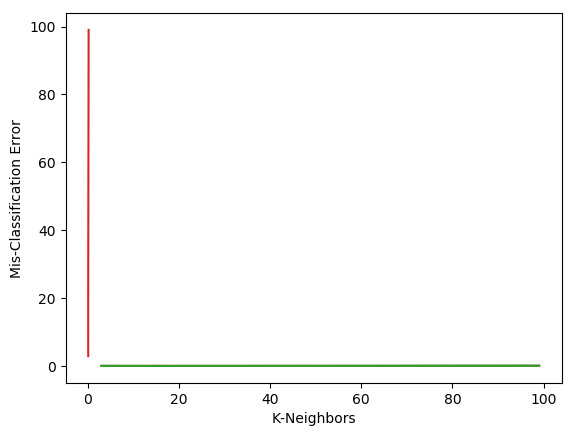

In [144]:
plt.show()

# Now try with Neural Networks

In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

data_neural=df2.values
x_neural=data_neural[:,:-1]
y_neural=data_neural[:,-1]
y_check=np_utils.to_categorical(y_neural)
x_train_n,x_test_n,y_train_n,y_test_n=train_test_split(x_neural,y_check,test_size=0.3,random_state=11)

In [20]:
num_labels = y_train_n.shape[1]

In [21]:
print(num_labels)

12


In [22]:
num_labels = y_train_n.shape[1]
filter_size = 2

# build model
model = Sequential()

model.add(Dense(256, input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# Now let us train our model

model.fit(x_train_n, y_train_n, batch_size=32, epochs=70, validation_data=(x_test_n, y_test_n))
#This is the result I got on training for 5 epochs
#

Train on 5895 samples, validate on 2527 samples
Epoch 1/70
5895/5895 [==============================] - 3s 499us/step - loss: 14.6333 - acc: 0.0833 - val_loss: 14.7036 - val_acc: 0.0831
Epoch 2/70
5895/5895 [==============================] - 2s 403us/step - loss: 14.6422 - acc: 0.0853 - val_loss: 13.5430 - val_acc: 0.1468
Epoch 3/70
5895/5895 [==============================] - 2s 353us/step - loss: 14.4391 - acc: 0.0977 - val_loss: 13.7090 - val_acc: 0.1433
Epoch 4/70
5895/5895 [==============================] - 2s 316us/step - loss: 14.0740 - acc: 0.1226 - val_loss: 13.5090 - val_acc: 0.1591
Epoch 5/70
5895/5895 [==============================] - 2s 322us/step - loss: 14.0461 - acc: 0.1264 - val_loss: 13.4803 - val_acc: 0.1603
Epoch 6/70
5895/5895 [==============================] - 2s 314us/step - loss: 13.9814 - acc: 0.1308 - val_loss: 13.5875 - val_acc: 0.1567
Epoch 7/70
5895/5895 [==============================] - 2s 322us/step - loss: 13.6687 - acc: 0.1494 - val_loss: 13.4879 - va

In [ ]:
pd.concat()

In [36]:
df1=pd.DataFrame([[1,2,3],[4,5,6]])

In [37]:
df2=pd.DataFrame([[7,8,9],[10,11,12]])

In [39]:
pd.concat([df1,df2])

,0,1,2
0,1,2,3
1,4,5,6
0,7,8,9
1,10,11,12
